In [ ]:
# Canonicar DS

## Imports

In [106]:
%%capture
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import shap as shap

## Device Configuration

In [107]:
# scikit-learn regression don't use GPU, may be good for other stuff
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Collection & Preprocessing

In [ ]:
# file_pathy = "Extended_Lap_Data.csv"
# df = pd.read_csv(file_pathy)


In [ ]:
# df.head()

,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,accel_x,accel_y,accel_z,ang_vel_x,ang_vel_y,ang_vel_z,latitude,longitude,altitude,velocity,lap time,vehicle_name,track_type
0,22.542943,0.122112,442.490063,95.765057,6.432723,-6.547775,20.322382,9.274060,0.068585,0.038409,0.892182,32.080147,34.780040,1.992749,1.513141,77.608764,vehicle.audi.a2,easy
1,22.910251,0.119391,425.138077,104.973049,6.825671,-0.001486,0.016748,10.449987,0.001470,0.001399,0.239490,32.080254,34.779947,2.038629,2.140390,78.296386,vehicle.citroen.c3,easy
2,22.948924,0.098013,540.045886,76.629806,5.702161,0.054540,-0.007307,9.329839,0.012908,0.000215,-0.000904,32.080286,34.779963,2.006428,1.149832,79.710762,vehicle.micro.microlino,easy
3,23.292335,0.117043,317.136144,107.774746,7.992851,4.427134,9.200725,9.840771,0.009263,0.000280,0.099016,32.080298,34.779992,1.969221,1.885082,75.803364,vehicle.dodge.charger_police,easy
4,23.545707,0.132455,324.638755,97.086055,6.987068,-6.353961,8.077399,9.771209,-0.002384,0.002950,0.731868,32.080255,34.780055,1.988673,2.242577,75.599768,vehicle.audi.tt,easy


In [ ]:
# vehicle_type_dict = {
#     "vehicle.yamaha.yzf": "Motorcycle",
#     "vehicle.carlamotors.carlacola": "Truck",
#     "vehicle.mini.cooper_s_2021": "Car",
#     "vehicle.mercedes.sprinter": "Van",
#     "vehicle.ford.ambulance": "Van",
#     "vehicle.kawasaki.ninja": "Motorcycle",
#     "vehicle.carlamotors.firetruck": "Truck",
#     "vehicle.ford.mustang": "Car",
#     "vehicle.volkswagen.t2_2021": "Van",
#     "vehicle.vespa.zx125": "Motorcycle",
#     "vehicle.lincoln.mkz_2020": "Car",
#     "vehicle.toyota.prius": "Car",
#     "vehicle.harley-davidson.low_rider": "Motorcycle",
#     "vehicle.audi.tt": "Car",
#     "vehicle.dodge.charger_2020": "Car",
#     "vehicle.nissan.patrol_2021": "Car",
#     "vehicle.tesla.cybertruck": "Truck",
# }


In [ ]:
# # remove any line with a vehicle_name not in the list

# df = df[df["vehicle_name"].isin(vehicle_type_dict.keys())]

# df.head()


,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,accel_x,accel_y,accel_z,ang_vel_x,ang_vel_y,ang_vel_z,latitude,longitude,altitude,velocity,lap time,vehicle_name,track_type
4,23.545707,0.132455,324.638755,97.086055,6.987068,-6.353961,8.077399,9.771209,-0.002384,0.002950,0.731868,32.080255,34.780055,1.988673,2.242577,75.599768,vehicle.audi.tt,easy
16,13.814251,0.005381,171.889330,37.552754,5.756017,-2.504076,4.840102,9.759463,0.004164,0.001745,0.354031,41.999401,2.000945,1.988808,3.532316,43.230682,vehicle.audi.tt,easy
20,13.826086,0.001621,188.974015,38.833041,1.225023,0.524179,0.059079,9.596846,0.019099,-0.007923,0.284341,41.999252,2.000770,1.966493,4.265146,45.067932,vehicle.harley-davidson.low_rider,easy
21,13.841473,0.007125,172.717915,42.547029,4.402779,-0.371271,-0.484408,9.871880,-0.011801,0.000157,0.103812,41.999324,2.000883,2.000430,4.628959,43.225411,vehicle.dodge.charger_2020,easy
22,14.176885,0.007569,214.845518,47.263151,0.330608,3.721761,13.703325,9.639760,0.040095,0.003298,0.458207,41.999249,2.000432,1.995100,4.556846,45.721086,vehicle.ford.ambulance,easy


In [ ]:
# # add vehicle type to the dataframe by vehicle name

# df["vehicle_type"] = df["vehicle_name"].map(vehicle_type_dict)

In [ ]:
# # Load JSON data
# json_file_path = "cars_modified.json"
# with open(json_file_path, "r") as json_file:
#     json_data = json.load(json_file)

# # Extract relevant data for each vehicle
# vehicle_data = {}
# for vehicle_name, vehicle_info in json_data.items():
#     vehicle_data[vehicle_name] = {
#         "mass": vehicle_info.get("mass"),
#         "drag_coefficient": vehicle_info.get("drag_coefficient"),
#         "center_of_mass_x": vehicle_info.get("center_of_mass_x"),
#         "center_of_mass_y": vehicle_info.get("center_of_mass_y"),
#         "center_of_mass_z": vehicle_info.get("center_of_mass_z"),
#         "max_rpm": vehicle_info.get("max_rpm"),
#         "moi": vehicle_info.get("moi"),
#         "clutch_strength": vehicle_info.get("clutch_strength"),
#         "gear_switch_time": vehicle_info.get("gear_switch_time"),
#         "front_left_wheel_tire_friction": vehicle_info.get("front_left_wheel_tire_friction"),
#         "front_left_wheel_damping_rate": vehicle_info.get("front_left_wheel_damping_rate"),
#         "front_left_wheel_max_steer_angle": vehicle_info.get("front_left_wheel_max_steer_angle"),
#         "front_left_wheel_radius": vehicle_info.get("front_left_wheel_radius"),
#         "front_left_wheel_max_brake_torque": vehicle_info.get("front_left_wheel_max_brake_torque"),
#         "front_left_wheel_max_handbrake_torque": vehicle_info.get("front_left_wheel_max_handbrake_torque"),
#         "front_left_wheel_lat_stiff_max_load": vehicle_info.get("front_left_wheel_lat_stiff_max_load"),
#         "front_left_wheel_lat_stiff_value": vehicle_info.get("front_left_wheel_lat_stiff_value"),
#         "front_left_wheel_long_stiff_value": vehicle_info.get("front_left_wheel_long_stiff_value"),
#         "front_left_wheel_position_x": vehicle_info.get("front_left_wheel_position_x"),
#         "front_left_wheel_position_y": vehicle_info.get("front_left_wheel_position_y"),
#         "front_left_wheel_position_z": vehicle_info.get("front_left_wheel_position_z"),
#         "front_right_wheel_tire_friction": vehicle_info.get("front_right_wheel_tire_friction"),
#         "front_right_wheel_damping_rate": vehicle_info.get("front_right_wheel_damping_rate"),
#         "front_right_wheel_max_steer_angle": vehicle_info.get("front_right_wheel_max_steer_angle"),
#         "front_right_wheel_radius": vehicle_info.get("front_right_wheel_radius"),
#         "front_right_wheel_max_brake_torque": vehicle_info.get("front_right_wheel_max_brake_torque"),
#         "front_right_wheel_max_handbrake_torque": vehicle_info.get("front_right_wheel_max_handbrake_torque"),
#         "front_right_wheel_lat_stiff_max_load": vehicle_info.get("front_right_wheel_lat_stiff_max_load"),
#         "front_right_wheel_lat_stiff_value": vehicle_info.get("front_right_wheel_lat_stiff_value"),
#         "front_right_wheel_long_stiff_value": vehicle_info.get("front_right_wheel_long_stiff_value"),
#         "front_right_wheel_position_x": vehicle_info.get("front_right_wheel_position_x"),
#         "front_right_wheel_position_y": vehicle_info.get("front_right_wheel_position_y"),
#         "front_right_wheel_position_z": vehicle_info.get("front_right_wheel_position_z"),
#         "rear_left_wheel_tire_friction": vehicle_info.get("rear_left_wheel_tire_friction"),
#         "rear_left_wheel_damping_rate": vehicle_info.get("rear_left_wheel_damping_rate"),
#         "rear_left_wheel_max_steer_angle": vehicle_info.get("rear_left_wheel_max_steer_angle"),
#         "rear_left_wheel_radius": vehicle_info.get("rear_left_wheel_radius"),
#         "rear_left_wheel_max_brake_torque": vehicle_info.get("rear_left_wheel_max_brake_torque"),
#         "rear_left_wheel_max_handbrake_torque": vehicle_info.get("rear_left_wheel_max_handbrake_torque"),
#         "rear_left_wheel_lat_stiff_max_load": vehicle_info.get("rear_left_wheel_lat_stiff_max_load"),
#         "rear_left_wheel_lat_stiff_value": vehicle_info.get("rear_left_wheel_lat_stiff_value"),
#         "rear_left_wheel_long_stiff_value": vehicle_info.get("rear_left_wheel_long_stiff_value"),
#         "rear_left_wheel_position_x": vehicle_info.get("rear_left_wheel_position_x"),
#         "rear_left_wheel_position_y": vehicle_info.get("rear_left_wheel_position_y"),
#         "rear_left_wheel_position_z": vehicle_info.get("rear_left_wheel_position_z"),
#         "rear_right_wheel_tire_friction": vehicle_info.get("rear_right_wheel_tire_friction"),
#         "rear_right_wheel_damping_rate": vehicle_info.get("rear_right_wheel_damping_rate"),
#         "rear_right_wheel_max_steer_angle": vehicle_info.get("rear_right_wheel_max_steer_angle"),
#         "rear_right_wheel_radius": vehicle_info.get("rear_right_wheel_radius"),
#         "rear_right_wheel_max_brake_torque": vehicle_info.get("rear_right_wheel_max_brake_torque"),
#         "rear_right_wheel_max_handbrake_torque": vehicle_info.get("rear_right_wheel_max_handbrake_torque"),
#         "rear_right_wheel_lat_stiff_max_load": vehicle_info.get("rear_right_wheel_lat_stiff_max_load"),
#         "rear_right_wheel_lat_stiff_value": vehicle_info.get("rear_right_wheel_lat_stiff_value"),
#         "rear_right_wheel_long_stiff_value": vehicle_info.get("rear_right_wheel_long_stiff_value"),
#         "rear_right_wheel_position_x": vehicle_info.get("rear_right_wheel_position_x"),
#         "rear_right_wheel_position_y": vehicle_info.get("rear_right_wheel_position_y"),
#         "rear_right_wheel_position_z": vehicle_info.get("rear_right_wheel_position_z")
#     }

# # Create a DataFrame from the vehicle data
# vehicle_df = pd.DataFrame.from_dict(vehicle_data, orient="index")

# # Merge the vehicle data with the CSV data
# df = df.merge(vehicle_df, left_on="vehicle_name", right_index=True, how="left")

# # Save the updated DataFrame to a new CSV file
# df.to_csv("Extended_Lap_Data_Updated.csv", index=False)

# print("Data merged and saved to Extended_Lap_Data_Updated.csv")

Data merged and saved to Extended_Lap_Data_Updated.csv


In [ ]:
# df_updated = pd.read_csv("Extended_Lap_Data_Updated.csv")

In [ ]:
# df_updated.head()

,vehicle_name,vehicle_type,track_type,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,accel_x,accel_y,...,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
0,vehicle.audi.tt,Car,easy,23.545707,0.132455,324.638755,97.086055,6.987068,-6.353961,8.077399,...,87.377563,34.0,700,1400,3,20,3000,9838.762695,4073.746094,87.377563
1,vehicle.audi.tt,Car,easy,13.814251,0.005381,171.889330,37.552754,5.756017,-2.504076,4.840102,...,87.377563,34.0,700,1400,3,20,3000,9838.762695,4073.746094,87.377563
2,vehicle.harley-davidson.low_rider,Motorcycle,easy,13.826086,0.001621,188.974015,38.833041,1.225023,0.524179,0.059079,...,84.417114,35.5,1500,3000,2,17,1000,10970.796880,-611.760986,84.417114
3,vehicle.dodge.charger_2020,Car,easy,13.841473,0.007125,172.717915,42.547029,4.402779,-0.371271,-0.484408,...,86.128242,35.0,1000,2000,3,20,3000,3145.575928,13312.832030,86.128242
4,vehicle.ford.ambulance,Van,easy,14.176885,0.007569,214.845518,47.263151,0.330608,3.721761,13.703325,...,79.684296,35.0,800,1600,2,17,1000,-1845.221069,1593.346680,79.684296


In [ ]:
# # each column that only contains zero or one value is removed

# df_updated = df_updated.loc[:, df_updated.nunique() != 1]

In [ ]:
# # Save the updated DataFrame to a new CSV file
# df_updated.to_csv("Extended_Lap_Data_Updated_unique.csv", index=False)
# df_updated.head()

,vehicle_name,vehicle_type,track_type,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,accel_x,accel_y,...,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
0,vehicle.audi.tt,Car,easy,23.545707,0.132455,324.638755,97.086055,6.987068,-6.353961,8.077399,...,87.377563,34.0,700,1400,3,20,3000,9838.762695,4073.746094,87.377563
1,vehicle.audi.tt,Car,easy,13.814251,0.005381,171.889330,37.552754,5.756017,-2.504076,4.840102,...,87.377563,34.0,700,1400,3,20,3000,9838.762695,4073.746094,87.377563
2,vehicle.harley-davidson.low_rider,Motorcycle,easy,13.826086,0.001621,188.974015,38.833041,1.225023,0.524179,0.059079,...,84.417114,35.5,1500,3000,2,17,1000,10970.796880,-611.760986,84.417114
3,vehicle.dodge.charger_2020,Car,easy,13.841473,0.007125,172.717915,42.547029,4.402779,-0.371271,-0.484408,...,86.128242,35.0,1000,2000,3,20,3000,3145.575928,13312.832030,86.128242
4,vehicle.ford.ambulance,Van,easy,14.176885,0.007569,214.845518,47.263151,0.330608,3.721761,13.703325,...,79.684296,35.0,800,1600,2,17,1000,-1845.221069,1593.346680,79.684296


In [148]:
# df = pd.read_csv("Extended_Lap_Data_Updated_unique.csv")
df = pd.read_csv("Cleaned_CARLA_Dataset__Outliers_Removed_.csv")


In [149]:
df

,vehicle_name,vehicle_type,track_type,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,...,front_left_wheel_max_brake_torque,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_left_wheel_long_stiff_value,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value
0,6,1,0,15.259818,0.008359,244.615107,50.570863,4.728705,4.831053,47.710409,...,1500,2,17,1000,35.5,1500,3000,2,17,1000
1,8,0,0,15.304208,0.010941,231.204001,52.401402,4.897946,5.998118,48.478883,...,800,3,20,3000,35.5,800,1600,3,20,3000
2,7,1,1,18.261644,0.018468,292.547895,130.613821,1.010767,4.493952,45.446641,...,1500,2,17,1000,32.0,1500,3000,2,17,1000
3,4,3,1,16.852072,0.013364,369.990881,125.554860,10.176865,5.316543,78.844675,...,800,2,17,1000,35.0,800,1600,2,17,1000
4,16,1,0,16.175725,0.002698,281.628377,56.572882,21.760941,1.717143,48.157999,...,1500,2,17,1000,31.0,1500,3000,2,17,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39297,9,3,0,15.936279,0.016037,256.438538,85.483208,7.832109,4.863938,80.849471,...,1500,5,20,3000,35.0,1500,3000,5,20,3000
39298,14,1,1,18.240501,-0.005356,322.081596,135.508867,21.359659,3.715929,56.343562,...,1500,2,17,1000,21.5,1500,3000,2,17,1000
39299,12,2,1,18.844914,0.014885,135.816590,109.175381,17.399341,4.175138,48.344135,...,1600,2,17,1000,53.5,1600,3200,2,17,1000
39300,1,2,0,14.703483,0.008023,242.332102,50.999576,5.631493,6.524652,47.125784,...,2700,5,20,3000,46.0,2700,5400,5,20,3000


In [150]:
# Potentially useful numeric features (verify these columns exist in your data)
numeric_features = [
    'average_speed', 'fuel_consumption', 'total_steering', 'total_throttle',
    'total_brake', 'velocity', 'mass', 'drag_coefficient',
    'center_of_mass_x', 'center_of_mass_z', 'max_rpm', 'clutch_strength',
    'gear_switch_time', 'front_left_wheel_radius', 'front_left_wheel_max_brake_torque',
    'front_left_wheel_lat_stiff_max_load', 'front_left_wheel_lat_stiff_value',
    'front_left_wheel_long_stiff_value', 'rear_right_wheel_radius',
    'rear_right_wheel_max_brake_torque', 'rear_right_wheel_max_handbrake_torque',
    'rear_right_wheel_lat_stiff_max_load', 'rear_right_wheel_lat_stiff_value',
    'rear_right_wheel_long_stiff_value'
]

# Categorical features
categorical_features = [
    'vehicle_name',  # many possible categories
    'vehicle_type',  # e.g., Car, Van, Motorcycle, etc.
    'track_type'     # e.g., easy, medium, hard
]

# Combine into single feature list
all_features = numeric_features + categorical_features

# Target variable
target = 'lap time'

# Subset the DataFrame
df_subset = df[all_features + [target]].dropna()  # ensure no NaNs

# Inspect the shape
print("Data subset shape:", df_subset.shape)
print("Features:", all_features)
print("Target:", target)

Data subset shape: (39302, 28)
Features: ['average_speed', 'fuel_consumption', 'total_steering', 'total_throttle', 'total_brake', 'velocity', 'mass', 'drag_coefficient', 'center_of_mass_x', 'center_of_mass_z', 'max_rpm', 'clutch_strength', 'gear_switch_time', 'front_left_wheel_radius', 'front_left_wheel_max_brake_torque', 'front_left_wheel_lat_stiff_max_load', 'front_left_wheel_lat_stiff_value', 'front_left_wheel_long_stiff_value', 'rear_right_wheel_radius', 'rear_right_wheel_max_brake_torque', 'rear_right_wheel_max_handbrake_torque', 'rear_right_wheel_lat_stiff_max_load', 'rear_right_wheel_lat_stiff_value', 'rear_right_wheel_long_stiff_value', 'vehicle_name', 'vehicle_type', 'track_type']
Target: lap time


In [152]:
# Code Block 3 - ColumnTransformer for encoding + scaling

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# 1. Pipeline for numeric features (scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # or MinMaxScaler()
])

# 2. Pipeline for categorical features (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Separate features (X) and target (y)
X = df_subset.drop(columns=[target])
y = df_subset[target]

# Apply fit_transform on training data, transform on test
# We'll do that after splitting, so see next block for integration


In [153]:
#prints

print("X shape:", X.shape)
print("y shape:", y.shape)




X shape: (39302, 27)
y shape: (39302,)


In [155]:
y

0        47.710409
1        48.478883
2        45.446641
3        78.844675
4        48.157999
           ...    
39297    80.849471
39298    56.343562
39299    48.344135
39300    47.125784
39301    65.303060
Name: lap time, Length: 39302, dtype: float64

In [23]:
# df_new = pd.read_csv("Expanded_CARLA_Lap_Data.csv")

In [24]:
# df_new

In [25]:
# #shuffle the rows
# df_new = df_new.sample(frac=1).reset_index(drop=True)
# df_new

In [26]:
# #count easy and hard

# df_new['track_type'].value_counts()

In [27]:
# from sklearn.preprocessing import LabelEncoder

# # Initialize the LabelEncoder
# label_encoder = LabelEncoder()

# # Encode categorical variables and create dictionaries
# vehicle_name_mapping = dict(zip(df_new['vehicle_name'].unique(), label_encoder.fit_transform(df_new['vehicle_name'].unique())))
# df_new['vehicle_name'] = df_new['vehicle_name'].map(vehicle_name_mapping)

# vehicle_type_mapping = dict(zip(df_new['vehicle_type'].unique(), label_encoder.fit_transform(df_new['vehicle_type'].unique())))
# df_new['vehicle_type'] = df_new['vehicle_type'].map(vehicle_type_mapping)

# track_type_mapping = dict(zip(df_new['track_type'].unique(), label_encoder.fit_transform(df_new['track_type'].unique())))
# df_new['track_type'] = df_new['track_type'].map(track_type_mapping)

# # Check the first few rows to see the changes
# df_new.head()

# # Print the mappings
# print("Vehicle Name Mapping:", vehicle_name_mapping)
# print("Vehicle Type Mapping:", vehicle_type_mapping)
# print("Track Type Mapping:", track_type_mapping)

In [28]:
# # Separate features and target variables
# X = df_new.drop(columns=['lap time'])

# y_lap_time = df_new['lap time']
# y_track_type = df_new['track_type']

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [29]:
# # Convert the scaled data back to a DataFrame for easier access
# X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# # Look at the scaled fuel consumption column
# scaled_fuel_consumption = X_scaled_df['fuel_consumption']
# print(scaled_fuel_consumption.head())

#### Train-test split

In [159]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

In [ ]:
# # Split for lap time prediction
# X_train_lap, X_test_lap, y_train_lap, y_test_lap = train_test_split(X_scaled, y_lap_time, test_size=0.3, random_state=42)

# # Split for track type prediction
# X_train_track, X_test_track, y_train_track, y_test_track = train_test_split(X_scaled, y_track_type, test_size=0.3, random_state=42)

In [127]:
#shapes

print(X_train_lap.shape)
print(X_test_lap.shape)

(27511, 4)
(11791, 4)


### Linear Regression

In [128]:
from sklearn.linear_model import LinearRegression

#### Fit models and compute MSE, RMSE, R² scores

In [160]:
# # Linear Regression
# lr = LinearRegression()
# lr.fit(X_train_lap, y_train_lap)
# y_pred_lr = lr.predict(X_test_lap)
# mse_lr = mean_squared_error(y_test_lap, y_pred_lr)
# r2_lr = r2_score(y_test_lap, y_pred_lr)
# print(f"Linear Regression - MSE: {mse_lr}, R²: {r2_lr}")


# Example: Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.3f}")

Linear Regression - MSE: 262.53, R²: 0.267


#### Visualize plots

#### Feature importance ranking

### Gaussian Process

In [130]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error

The model uses a Radial Basis Function (RBF) kernel, which allows it to capture nonlinear relationships.

The ConstantKernel defines the scale of variation.

#### Fit models and compute MSE, RMSE, R² scores

In [175]:
# Gaussian Process Regression
kernel = C(1.0, (1e-3, 1e4)) * RBF(1.0, (1e-3, 1e3))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_lap, y_train_lap)
y_pred_gpr = gpr.predict(X_test_lap)
mse_gpr = mean_squared_error(y_test_lap, y_pred_gpr)
mae_gpr = mean_absolute_error(y_test_lap, y_pred_gpr)
r2_gpr = r2_score(y_test_lap, y_pred_gpr)
print(f"Gaussian Process Regression - MSE: {mse_gpr}, MAE: {mae_gpr}, R²: {r2_gpr}")

KeyboardInterrupt: 

#### Another try with another kernel

#### Visualize plots

#### Feature importance ranking

### DecisionTreeRegressor

In [131]:
from sklearn.tree import DecisionTreeRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [162]:
# dt = DecisionTreeRegressor(max_depth=4, random_state=42)
# dt.fit(X_train_lap, y_train_lap)
# y_pred_dt = dt.predict(X_test_lap)
# mse_dt = mean_squared_error(y_test_lap, y_pred_dt)
# r2_dt = r2_score(y_test_lap, y_pred_dt)
# print(f"Decision Tree Regression - MSE: {mse_dt}, R²: {r2_dt}")

# Code Block 5.1 - Decision Tree with GridSearchCV

from sklearn.model_selection import GridSearchCV


dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Hyperparameter search space for Decision Tree
param_grid_dt = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=3,    # 3-fold cross-validation
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

print("Best params:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree - MSE: {mse_dt:.2f}, R²: {r2_dt:.3f}")


Best params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}
Decision Tree - MSE: 144.55, R²: 0.596


#### Visualize plots

#### Feature importance ranking

### Random Forest

In [133]:
from sklearn.ensemble import RandomForestRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [163]:
# rf = RandomForestRegressor(n_estimators=120, max_depth=6, random_state=42)
# rf.fit(X_train_lap, y_train_lap)
# y_pred_rf = rf.predict(X_test_lap)
# mse_rf = mean_squared_error(y_test_lap, y_pred_rf)
# r2_rf = r2_score(y_test_lap, y_pred_rf)
# print(f"Random Forest Regression - MSE: {mse_rf}, R²: {r2_rf}")


# Code Block 5.2 - Random Forest with GridSearchCV

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [6, 8, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.3f}")


Best params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Random Forest - MSE: 74.65, R²: 0.791


#### Visualize plots

#### Feature importance ranking

### Gradient Boosting

In [135]:
from sklearn.ensemble import GradientBoostingRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [164]:
# gb = GradientBoostingRegressor(n_estimators=120, learning_rate=0.01, max_depth=9, random_state=42)
# gb.fit(X_train_lap, y_train_lap)
# y_pred_gb = gb.predict(X_test_lap)
# mse_gb = mean_squared_error(y_test_lap, y_pred_gb)
# r2_gb = r2_score(y_test_lap, y_pred_gb)
# print(f"Gradient Boosting Regression - MSE: {mse_gb}, R²: {r2_gb}")

# Code Block 5.3 - Gradient Boosting with GridSearchCV

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 9]
}

grid_gb = GridSearchCV(
    gb_pipeline,
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)

print("Best params:", grid_gb.best_params_)
best_gb = grid_gb.best_estimator_

y_pred_gb = best_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MSE: {mse_gb:.2f}, R²: {r2_gb:.3f}")


Best params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 9, 'regressor__n_estimators': 200}
Gradient Boosting - MSE: 0.06, R²: 1.000


#### Visualize plots

#### Feature importance ranking

### Support Vector

In [137]:
from sklearn.svm import SVR

#### Fit models and compute MSE, RMSE, R² scores

In [165]:
# svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
# svr.fit(X_train_lap, y_train_lap)
# y_pred_svr = svr.predict(X_test_lap)
# mse_svr = mean_squared_error(y_test_lap, y_pred_svr)
# r2_svr = r2_score(y_test_lap, y_pred_svr)
# print(f"Support Vector Regression - MSE: {mse_svr}, R²: {r2_svr}")

# Code Block 5.4 - SVR with GridSearchCV

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

param_grid_svr = {
    'regressor__kernel': ['linear', 'rbf'],
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.01, 0.1, 0.5]
}

grid_svr = GridSearchCV(
    svr_pipeline,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_svr.fit(X_train, y_train)

print("Best params:", grid_svr.best_params_)
best_svr = grid_svr.best_estimator_

y_pred_svr = best_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR - MSE: {mse_svr:.2f}, R²: {r2_svr:.3f}")


Best params: {'regressor__C': 10, 'regressor__epsilon': 0.5, 'regressor__kernel': 'rbf'}
SVR - MSE: 173.42, R²: 0.516


#### Visualize plots

In [166]:
# Code Block 6 - Model Comparison

models_results = {
    "LinearRegression": {"MSE": mse_lr, "R2": r2_lr},
    "DecisionTree": {"MSE": mse_dt, "R2": r2_dt},
    "RandomForest": {"MSE": mse_rf, "R2": r2_rf},
    "GradientBoosting": {"MSE": mse_gb, "R2": r2_gb},
    "SVR": {"MSE": mse_svr, "R2": r2_svr}
}

for model, metrics in models_results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R^2: {metrics['R2']:.3f}")


LinearRegression -> MSE: 262.53, R^2: 0.267
DecisionTree -> MSE: 144.55, R^2: 0.596
RandomForest -> MSE: 74.65, R^2: 0.791
GradientBoosting -> MSE: 0.06, R^2: 1.000
SVR -> MSE: 173.42, R^2: 0.516


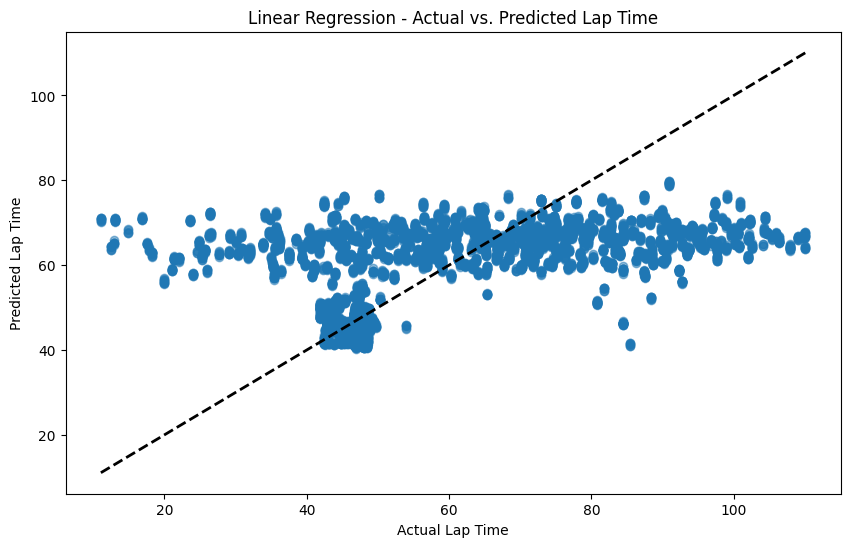

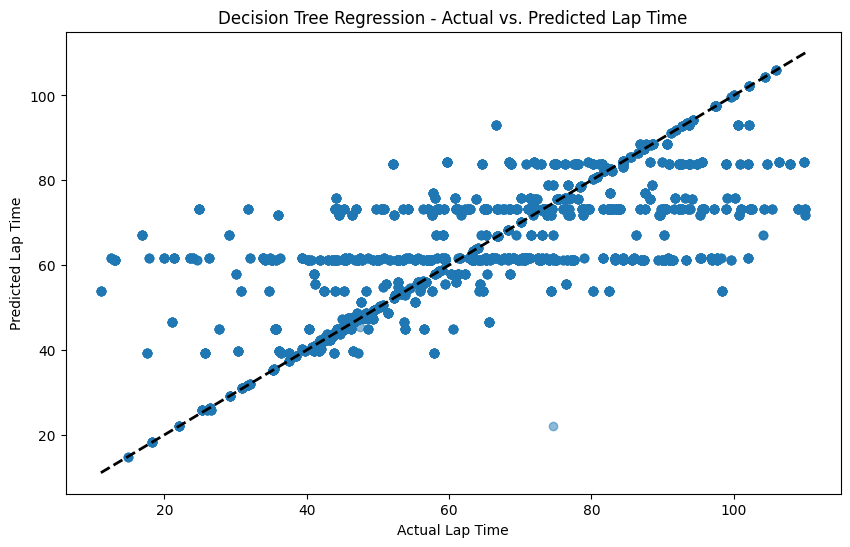

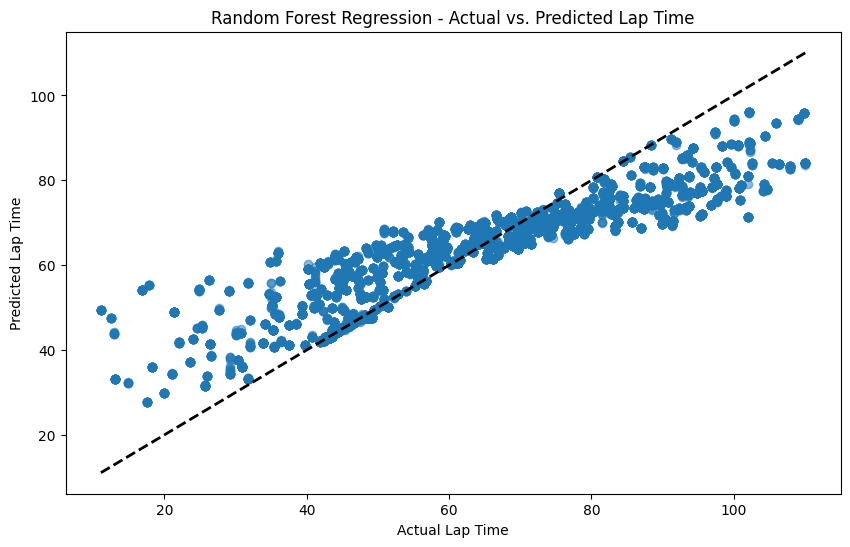

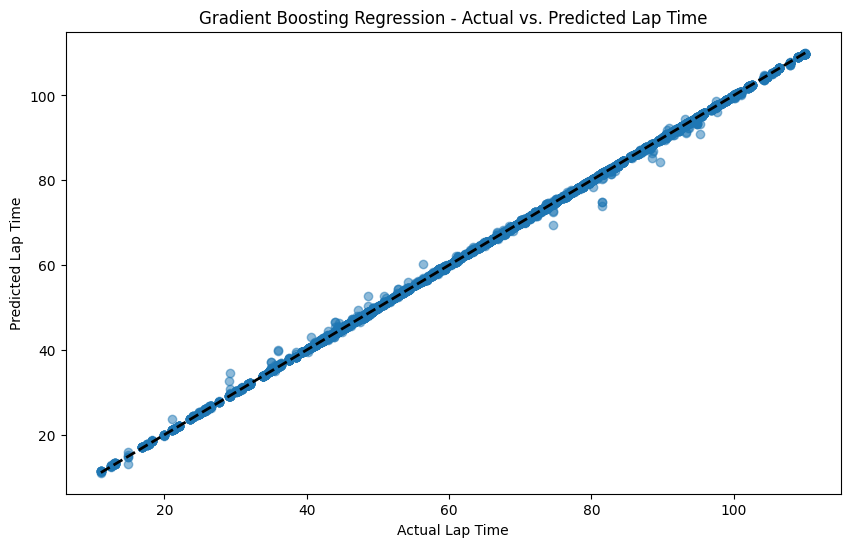

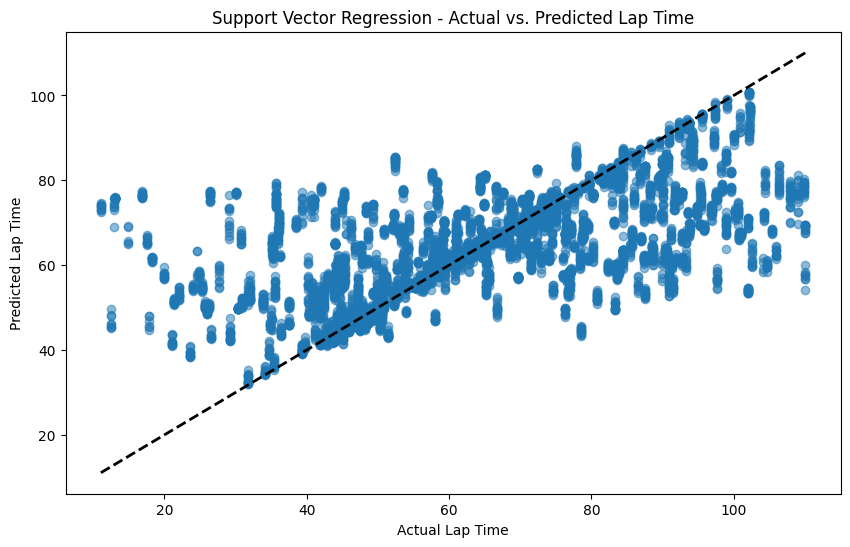

ValueError: x and y must be the same size

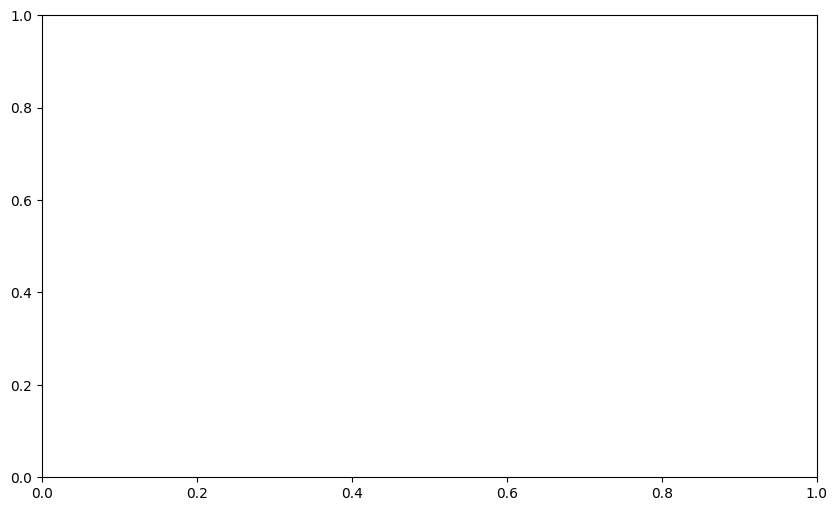

In [170]:

# Function to plot actual vs. predicted lap times
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Lap Time')
    plt.ylabel('Predicted Lap Time')
    plt.title(title)
    plt.show()

# Linear Regression
plot_actual_vs_predicted(y_test_lap, y_pred_lr, 'Linear Regression - Actual vs. Predicted Lap Time')

# Decision Tree Regression
plot_actual_vs_predicted(y_test_lap, y_pred_dt, 'Decision Tree Regression - Actual vs. Predicted Lap Time')

# Random Forest Regression
plot_actual_vs_predicted(y_test_lap, y_pred_rf, 'Random Forest Regression - Actual vs. Predicted Lap Time')

# Gradient Boosting Regression
plot_actual_vs_predicted(y_test_lap, y_pred_gb, 'Gradient Boosting Regression - Actual vs. Predicted Lap Time')

# Support Vector Regression
plot_actual_vs_predicted(y_test_lap, y_pred_svr, 'Support Vector Regression - Actual vs. Predicted Lap Time')

# Gaussian Process Regression
plot_actual_vs_predicted(y_test_lap, y_pred_gpr, 'Gaussian Process Regression - Actual vs. Predicted Lap Time')

##  Neural Networks for Regression

### Completion Time Prediction
- MLP
- **Activation**: ReLU, Tanh.
- **Loss Function**: MSE.

714    55.553118
605    91.645049
120    45.129613
208    47.612966
380    55.241534
Name: lap time, dtype: float64

In [311]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lap, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_lap, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_lap.values.reshape(-1, 1), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_lap.values.reshape(-1, 1), dtype=torch.float32).to(device)

device

device(type='cuda')

#### Network

In [312]:
import torch.nn as nn

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)
        self.fc9 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.batch_norm6 = nn.BatchNorm1d(32)
        self.batch_norm7 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.relu(self.batch_norm5(self.fc5(x)))
        x = self.relu(self.batch_norm6(self.fc6(x)))
        x = self.relu(self.batch_norm7(self.fc7(x)))
        x = self.fc8(x)
        x = self.fc9(x)  # No activation for regression
        return x

# Initialize model
input_dim = X_train_tensor.shape[1]
model = RegressionNN(input_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

RegressionNN(
  (fc1): Linear(in_features=27, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=8, bias=True)
  (fc9): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

#### Train

Epoch 10/500, Loss: 3680.5098, R² Score: -8.2089
Epoch 20/500, Loss: 3649.6536, R² Score: -8.0983
Epoch 30/500, Loss: 3619.5820, R² Score: -7.9747
Epoch 40/500, Loss: 3585.3069, R² Score: -7.8689
Epoch 50/500, Loss: 3546.5278, R² Score: -7.7772
Epoch 60/500, Loss: 3502.5349, R² Score: -7.6682
Epoch 70/500, Loss: 3451.2075, R² Score: -7.5640
Epoch 80/500, Loss: 3395.3569, R² Score: -7.3430
Epoch 90/500, Loss: 3333.0771, R² Score: -7.1115
Epoch 100/500, Loss: 3259.9771, R² Score: -7.0304
Epoch 110/500, Loss: 3179.7644, R² Score: -6.7394
Epoch 120/500, Loss: 3092.7905, R² Score: -6.5457
Epoch 130/500, Loss: 2996.7073, R² Score: -6.2232
Epoch 140/500, Loss: 2889.2664, R² Score: -6.1005
Epoch 150/500, Loss: 2778.7197, R² Score: -5.7042
Epoch 160/500, Loss: 2653.5498, R² Score: -5.4194
Epoch 170/500, Loss: 2529.5139, R² Score: -5.0738
Epoch 180/500, Loss: 2393.3044, R² Score: -4.7997
Epoch 190/500, Loss: 2254.3098, R² Score: -4.3446
Epoch 200/500, Loss: 2108.5129, R² Score: -3.9812
Epoch 210

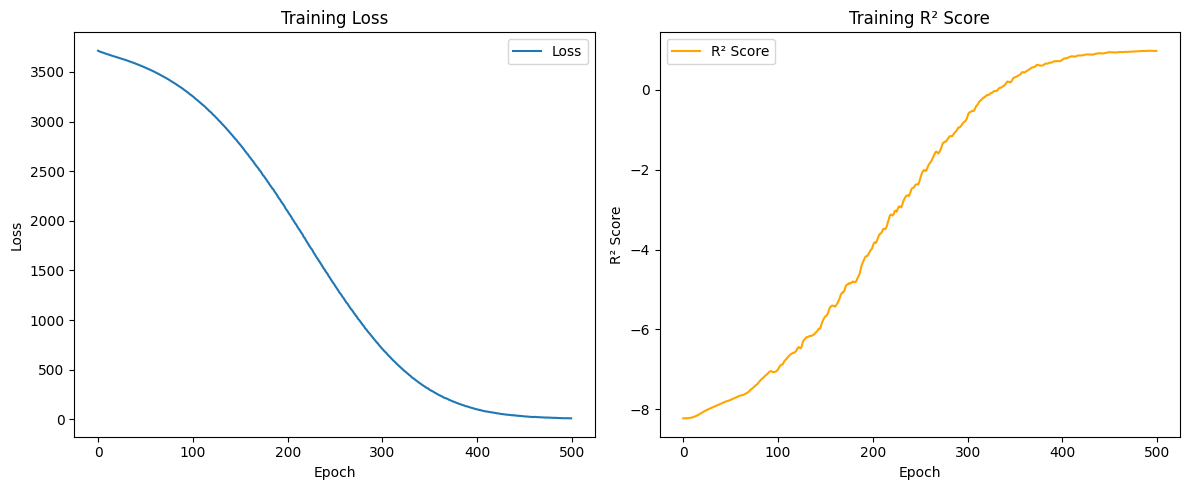

In [313]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Training Loop
epochs = 500
losses = []
r2_scores = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()

    # Store loss and R² score
    losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor)
        train_r2 = r2_score(y_train_tensor.cpu().numpy(), train_predictions.cpu().numpy())
        r2_scores.append(train_r2)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, R² Score: {train_r2:.4f}")

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, R² Score: {train_r2:.4f}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_r2 = r2_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())

print(f"Test Loss: {test_loss.item():.4f}, Test R² Score: {test_r2:.4f}")

# Plotting Loss and R² Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r2_scores, label='R² Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Training R² Score')
plt.legend()

plt.tight_layout()
plt.show()

#### Test & Evaluate

In [75]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Compute metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Train MSE: 1.1021
Test MSE: 2.5917
Test R²: -0.2565


### Stability Prediction
  - Combination of speed, acceleration, and tire pressure as inputs.
  - Embedding layer for vehicle type (categorical feature).

#### Network

#### Train

#### Test & Evaluate

## Classification - PySpark

### Decision Tree

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Naive Bayes

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### XGBoost

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Random Forest

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

## Clustering - PySpark
- Grouping Similar Driving Behaviors

### Evaluation & Visualization

#### Silhouette Score
- To measure clustering quality

#### PCA / t-SNE Plots
- Visualize clusters in 2D/3D